# Complex source reconstruction at fixed lens mass

This notebooks gives a working example of the modelling of a complex and realistic source with a pixel-based method based on sparsity in wavelets domain. The lens mass model is assumed to be known, and the source is reconstructed iteratively on a grid of pixel. By construction, the reconstructed surface brightness is sparse in wavelets space.

__author__: @aymgal

__last update__: 18/01/22

__IMPORTANT__: This notebook must be used with [this fork](https://github.com/aymgal/lenstronomy/tree/updt4slitronomy) of `lenstronomy`, as long as it has not been merged to the main repository.

In [1]:
import os
import sys
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import pysap

from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.ImSim.Numerics.grid import RegularGrid
from lenstronomy.Util import kernel_util
from lenstronomy.Util import image_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.util as lenstro_util

from slitronomy.Lensing.lensing_operator import LensingOperator
from slitronomy.Util.plot_util import nice_colorbar, log_cmap

np.random.seed(18)

%matplotlib inline

## Some global parameters to play with

The following parameters can be set :
- `supersampling_factor_source`: image pixel size to source pixel size ratio (aka subgrid resolution of source plane)
- `perfect_seeing`: if `True`, no PSF effect are included in simulation and modelling
- `parametric_ray_tracing`: if `True`, the mock lens is generating entirely with lenstronomy's ray tracing routine, otherwise the ray-tracing is performed with a pixel-based lensing operator
- `complex_source_type`: various realistic source types are available in this notebook:
    - `'galsim_single'`: a single galaxy generated with `galsim`
    - `'galsim_satellite'`: two side-by-side galaxies generated with `galsim`. A typical case where wavelets reconstruction perform well.
    - `'peaky_profile'`: two superimposed circular Sérsic profiles, tweaked such as it produces a very concentrated light distribution. Another typical case where the reconstruction outperforms parametric methods such as shapelets.

In [2]:
supersampling_factor_source = 2
perfect_seeing = False
parametric_ray_tracing = False
complex_source_type = 'galsim_single'

## Define image size, resolution, and noise-related properties

In [3]:
# data specifics
num_pix = 99  # cutout pixel size
delta_pix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2)
num_pix_source = int(num_pix*supersampling_factor_source)

background_rms = 0.05  # background noise per pixel
exp_time = 100  # exposure time in seconds, effectively for adding Poisson noise

psf_fwhm = 0.2  # full width half max of the gaussian PSF, in delta_pix units
psf_num_pix = 41  # PSF kernel size

## Create coordinate grids

In [4]:
# data specification (coordinates, etc.)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
    = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, inverse=False)

image_grid  = RegularGrid(num_pix, num_pix, Mpix2coord, ra_at_xy_0, dec_at_xy_0)
source_grid = RegularGrid(num_pix, num_pix, Mpix2coord, ra_at_xy_0, dec_at_xy_0, 
                          supersampling_factor=supersampling_factor_source)

ra_grid, dec_grid = image_grid.coordinates_evaluate
ra_grid_hd, dec_grid_hd = source_grid.coordinates_evaluate

## Instanciate Data and PSF classes

(41, 41)


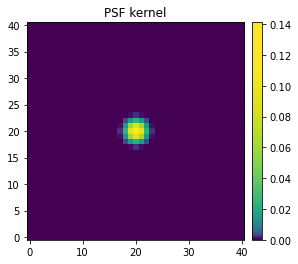

In [5]:
kwargs_data = {
    'background_rms': background_rms,
    'ra_at_xy_0': ra_at_xy_0, 
    'dec_at_xy_0': dec_at_xy_0, 
    'transform_pix2angle': Mpix2coord,
    'image_data': np.zeros((num_pix, num_pix))
}
if exp_time is not None: kwargs_data['exposure_time'] = exp_time
data_class = ImageData(**kwargs_data)

# PSF specification
if perfect_seeing:
    kwargs_psf = {'psf_type': 'NONE'}
else:
    psf_kernel = kernel_util.kernel_gaussian(psf_num_pix, delta_pix, psf_fwhm)
    print(psf_kernel.shape)
    kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel}
psf_class = PSF(**kwargs_psf)

plt.title("PSF kernel")
im = plt.imshow(psf_class.kernel_point_source, origin='lower', cmap=log_cmap('viridis', 0.01, 0.8))
nice_colorbar(im)
plt.show()

In [6]:
lens_model_list = ['PEMD']
kwargs_pemd = {'theta_E': 1.8, 'gamma': 2, 'center_x': 0.05, 'center_y': 0.05, 'e1': 0.1, 'e2': -0.2}
kwargs_lens = [kwargs_pemd]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of source light profiles
if complex_source_type in ['galsim_single', 'galsim_satellite']:
    source_dir = os.path.join('data', 'sources')
    galsim_index = 31
    delta_pix_mas = int(1000 * delta_pix)
    source_filename = 'source_galsim{}_pixsize{}mas_ssres{}.fits'.format(galsim_index, delta_pix_mas, 
                                                                         supersampling_factor_source)
    # load a source galaxy pre-generated with galsim
    with pf.open(os.path.join(source_dir, source_filename)) as f:
        galsim_source_subgrid = f[0].data
    # normalize so max is 1
    galsim_source_subgrid /= galsim_source_subgrid.max()
    galsim_delta_pix = image_grid.pixel_width / supersampling_factor_source
    # light profile in lenstronomy conventions
    source_model_list = ['INTERPOL']
    # specify scale, centering and rotation angle for interpolation on source grid
    kwargs_interpol_source = {'amp': 500, 'image': galsim_source_subgrid, 'scale': galsim_delta_pix,
                              'center_x': +0.1, 'center_y': -0.1, 'phi_G': 0}
    kwargs_source = [kwargs_interpol_source]
    
    if complex_source_type == 'galsim_satellite':
        # get another pre-processed source galaxy from galsim
        galsim_index = 1
        source_filename = 'source_galsim{}_pixsize{}mas_ssres{}.fits'.format(galsim_index, delta_pix_mas, 
                                                                             supersampling_factor_source)
        # load a source galaxy pre-generated with galsim
        with pf.open(os.path.join(source_dir, source_filename)) as f:
            galsim_source_subgrid = f[0].data
        # normalize so max is 1
        galsim_source_subgrid /= galsim_source_subgrid.max()
        source_model_list.append('INTERPOL')
        kwargs_interpol_source = {'amp': 500, 'image': galsim_source_subgrid, 'scale': galsim_delta_pix,
                                  'center_x': -1, 'center_y': -0.4, 'phi_G': 0}
        kwargs_source.append(kwargs_interpol_source)

elif complex_source_type == 'peaky_profile':
    source_model_list = ['SERSIC', 'SERSIC']
    kwargs_sersic_peaky = {'amp': 1, 'R_sersic': 0.2, 'n_sersic': 1, 'center_x': 0.3, 'center_y': -0.1}
    kwargs_sersic_smooth = {'amp': 1, 'R_sersic': 0.8, 'n_sersic': 4, 'center_x': 0.3, 'center_y': -0.1}
    kwargs_source = [kwargs_sersic_smooth, kwargs_sersic_peaky]

# create source model class
source_model_class = LightModel(light_model_list=source_model_list)

# list of lens light profiles
lens_light_model_list = []
kwargs_lens_light = [{}]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

## Generate true image of source

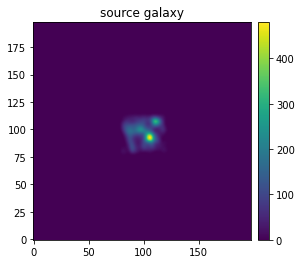

In [7]:
source_sim = source_model_class.surface_brightness(ra_grid_hd, dec_grid_hd, kwargs_source)
source_sim = lenstro_util.array2image(source_sim)

plt.title("source galaxy")
im = plt.imshow(source_sim, origin='lower') #, cmap=log_cmap('cubehelix', 0.03, 1))
nice_colorbar(im)
plt.show()

## Generate image of the lensed source

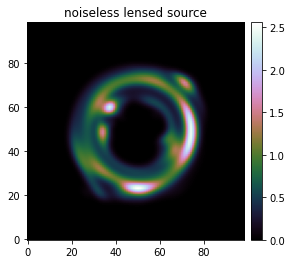

In [8]:
if parametric_ray_tracing:
    # specify supersampling when doing parametric ray-tracing 
    kwargs_numerics = {'supersampling_factor': 3}
    imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, 
                            lens_light_model_class, point_source_class=None, 
                            kwargs_numerics=kwargs_numerics)
    # generate the image
    image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps=None)
else:
    imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, 
                            lens_light_model_class, point_source_class=None)
    # build the pixelated lensing operator
    lensing_op_sim = LensingOperator(lens_model_class, image_grid, source_grid, num_pix, supersampling_factor_source,
                                     source_interpolation='bilinear')
    # ray tracing to generate the lensed source
    source_sim_1d = lenstro_util.image2array(source_sim)
    image_sim_no_noise_1d = lensing_op_sim.source2image(source_sim_1d, kwargs_lens=kwargs_lens)
    # PSF convolution
    image_sim_no_noise = imageModel.ImageNumerics.re_size_convolve(image_sim_no_noise_1d)
    
plt.title("noiseless lensed source")
im = plt.imshow(image_sim_no_noise, origin='lower', cmap='cubehelix')
nice_colorbar(im)
plt.show()

## Add noise

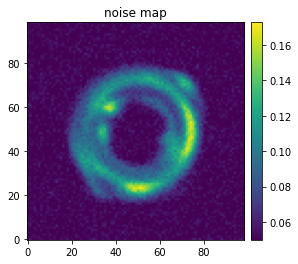

In [9]:
bkg = image_util.add_background(image_sim_no_noise, sigma_bkd=background_rms)
if exp_time is not None:
    poisson = image_util.add_poisson(image_sim_no_noise, exp_time=exp_time)
else:
    poisson = 0
noise = bkg + poisson
image_sim = image_sim_no_noise + noise

# update corresponding variables with simulated image and noise map
kwargs_data['image_data'] = image_sim
if kwargs_data.get('exposure_time', None) is None:
    kwargs_data['noise_map'] = background_rms * np.ones_like(image_sim)
data_class = ImageData(**kwargs_data)

plt.title("noise map")
im = plt.imshow(np.sqrt(data_class.C_D), origin='lower')
nice_colorbar(im)
plt.show()

## Visualize the lens & true source

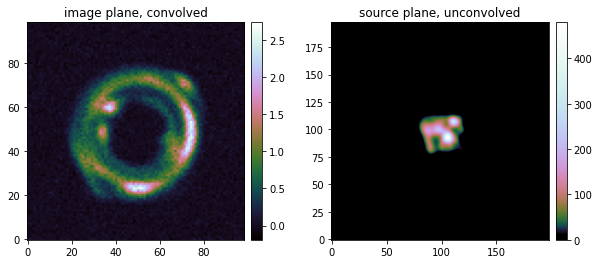

In [10]:
fig = plt.figure(figsize=(10, 4))

ax = plt.subplot(1, 2, 1)
ax.set_title("image plane, convolved")
im = ax.imshow(image_sim, origin='lower', cmap='cubehelix')
nice_colorbar(im)

ax = plt.subplot(1, 2, 2)
ax.set_title("source plane, unconvolved")
im = ax.imshow(source_sim, origin='lower', cmap=log_cmap('cubehelix', 0.03, 1))
nice_colorbar(im)

plt.show()

## Sparse optimizazion to reconstruct the source light

In [11]:
source_model_list_sparsefit = ['SLIT_STARLETS']
n_pix_x = image_sim.shape[0]*supersampling_factor_source
n_pix_y = image_sim.shape[1]*supersampling_factor_source
kwargs_starlets_source = {'n_scales': 6, 'n_pix_x': n_pix_x, 'n_pix_y': n_pix_y}
kwargs_source_sparsefit = [kwargs_starlets_source]
source_model_class_sparsefit = LightModel(light_model_list=source_model_list_sparsefit)

kwargs_special_sparsefit = {
    'delta_x_source_grid': 0,
    'delta_y_source_grid': 0,
}

likelihood_mask = None  # you can set any mask on imaging data here (binary array, 0s are masked pixels)

kwargs_pixelbased = {
    'include_regridding_error': False,
    'source_interpolation': 'bilinear',
    'supersampling_factor_source': supersampling_factor_source,
    'minimal_source_plane': False,
    'min_num_pix_source': 30,
    'min_threshold': 3,
    'threshold_increment_high_freq': 1,
    'threshold_decrease_type': 'exponential',
    'num_iter_source': 15,
    'num_iter_weights': 2,
    'verbose': True,
    'show_steps': False,
    'thread_count': 1,  # number of processors
}

imageFit = ImageLinearFit(data_class, psf_class=psf_class, 
                          lens_model_class=lens_model_class,
                          source_model_class=source_model_class_sparsefit,
                          likelihood_mask=likelihood_mask,
                          kwargs_pixelbased=kwargs_pixelbased)

In [12]:
kwargs_lens_mod = copy.deepcopy(kwargs_lens)
# uncomment the following if you want to test the effect of a change in mass profile slope by 10%
#kwargs_lens_mod[0]['gamma'] = kwargs_lens[0]['gamma'] * 0.9

start_time = time.time()
_ = imageFit.image_linear_solve(kwargs_lens_mod, 
                                kwargs_source=kwargs_source_sparsefit,
                                kwargs_lens_light=None,
                                kwargs_ps=None,
                                kwargs_special=kwargs_special_sparsefit)
end_time = time.time()
print("Runtime : {:.3f} s".format(end_time-start_time))

=== iteration 000-000 === : loss+reg = 601.0378|nan, red-chi2 = 9.5754|nan, step_diff = 14.6181|nan
=== iteration 000-010 === : loss+reg = 36.1074|nan, red-chi2 = 1.0960|nan, step_diff = 0.9569|nan
=== iteration 001-000 === : loss+reg = 96.4678|nan, red-chi2 = 3.2417|nan, step_diff = 8.7283|nan
=== iteration 001-010 === : loss+reg = 31.8786|nan, red-chi2 = 1.0141|nan, step_diff = 0.6410|nan
Runtime : 0.796 s


## Plot a visual summary of the optimization

0.98
Negative image pixels ? False (min = 1.44e-10)
Negative source pixels ? False (min = 0.00e+00)


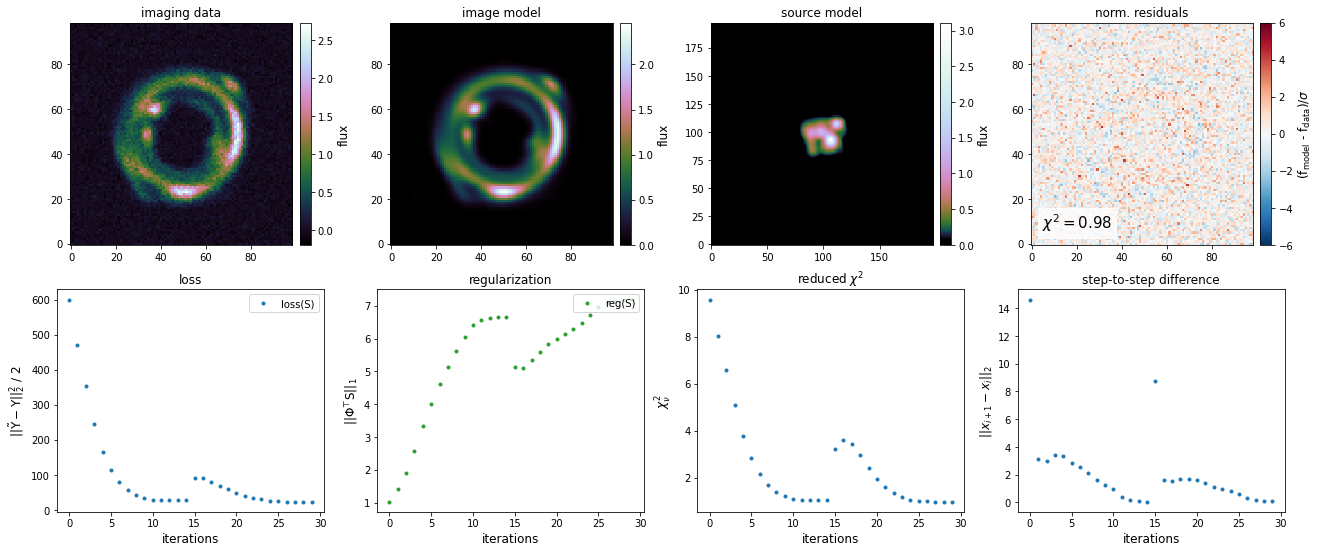

In [13]:
pixelSolver = imageFit.PixelSolver
print(pixelSolver.spectral_norm_source)

fig = pixelSolver.plot_results(vmin_res=-6, vmax_res=6, cmap_source=log_cmap('cubehelix', 0.03, 1))

In [14]:
print("Updated kwargs :", kwargs_source_sparsefit)
print(kwargs_source_sparsefit[0]['amp'].shape)

Updated kwargs : [{'n_scales': 6, 'n_pix_x': 198, 'n_pix_y': 198, 'scale': 0.039999999999999994, 'center_x': 0, 'center_y': 0, 'amp': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       1.99659621e-06, 1.77770835e-06, 1.57568286e-06])}]
(235224,)


## Compare reconstructed source with groundtruth

In [15]:
# get source reconstruction
print(kwargs_source_sparsefit)
source_estimate = source_model_class_sparsefit.surface_brightness(ra_grid_hd, dec_grid_hd, kwargs_source_sparsefit)
source_estimate = lenstro_util.array2image(source_estimate)

# flux normalization of true source for proper comparison
source_sim_comp = source_sim * delta_pix**2
source_estimate_comp = source_estimate

[{'n_scales': 6, 'n_pix_x': 198, 'n_pix_y': 198, 'scale': 0.039999999999999994, 'center_x': 0, 'center_y': 0, 'amp': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       1.99659621e-06, 1.77770835e-06, 1.57568286e-06])}]


3.0702845573425304 3.112010717391963


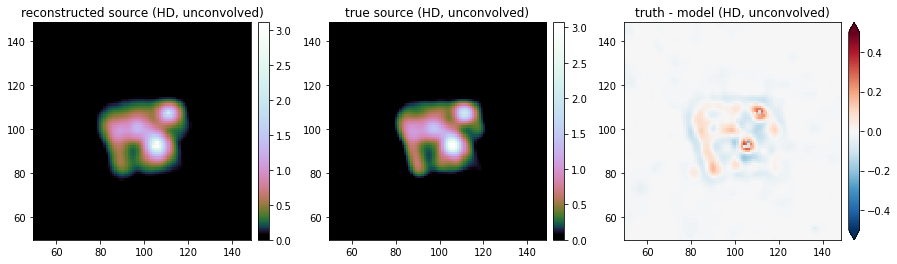

In [16]:
print(source_sim_comp.max(), source_estimate_comp.max())
residuals_source = source_sim_comp - source_estimate_comp

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax = axes[0]
ax.set_title("reconstructed source (HD, unconvolved)")
im = ax.imshow(source_estimate_comp, origin='lower', cmap=log_cmap('cubehelix', 0.03, 1))
ax.set_xlim(len(source_estimate_comp)/4, 3*len(source_estimate_comp)/4)
ax.set_ylim(len(source_estimate_comp)/4, 3*len(source_estimate_comp)/4)
nice_colorbar(im)
ax = axes[1]
ax.set_title("true source (HD, unconvolved)")
im = ax.imshow(source_sim_comp, origin='lower', cmap=log_cmap('cubehelix', 0.03, 1), vmin=0)
ax.set_xlim(len(source_sim_comp)/4, 3*len(source_sim_comp)/4)
ax.set_ylim(len(source_sim_comp)/4, 3*len(source_sim_comp)/4)
nice_colorbar(im)
ax = axes[2]
ax.set_title("truth - model (HD, unconvolved)")
ax.set_xlim(len(source_sim_comp)/4, 3*len(source_sim_comp)/4)
ax.set_ylim(len(source_sim_comp)/4, 3*len(source_sim_comp)/4)
im = ax.imshow(residuals_source, origin='lower', cmap='RdBu_r', vmin=-0.5, vmax=0.5)
nice_colorbar(im, colorbar_kwargs={'extend': 'both'})

plt.show()

**Side note**: when reconstructin sources generated with `galsim`, the patterns seen in the source plane residual map may come from noise features already present in the true source, and are not only due to inaccuracies reconstruction by the optimization algorithm.

## Compute some metrics

The metrics are the ones defined in Joseph+19 (original SLIT paper).
- SDR : Source Distortion Ratio (source plane metric)
- QOR : Quality Of Residuals (image plane metric)

In [17]:
from metrics import SDR, QOR
print("SDR =", SDR(source_sim_comp, source_estimate_comp))
print("SDR (restricted area) =", SDR(source_sim_comp[66:126, 76:136], source_estimate_comp[66:126, 76:136]))
#plt.imshow(source_sim_comp[66:126, 76:136], origin='lower')
#plt.show()

print("QOR =", QOR(image_sim, pixelSolver.image_model(), np.sqrt(data_class.C_D)))

SDR = 10.033980824933419
SDR (restricted area) = 10.131314804519754
QOR = 0.9815760946408899
